# Creating and extracting information from saliency maps
* organizing code
* removing multiclass case
* extract quantitative information from the maps

In [1]:
from prep_test_data import *
from pathlib import Path
import json
import torch
from matplotlib import pyplot as plt
import shutil
import numpy as np
import cv2
import csv

-------------------------------------------------------

## Main methods above

In [3]:
def create_maps_folders(main_folder, beat, labels, delete_prior):
    if delete_prior and Path(main_folder).exists():
        shutil.rmtree(main_folder)
    for label in labels:
        folder = Path(main_folder) / f"label_{beat}_beat/"
        Path(folder / label).mkdir(parents=True, exist_ok=True)
    return folder

In [4]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [4]:
def saliency_maps(model, data, main_folder, n_batches=None):
    classes = data["test"].dataset.classes
    for i, (inputs, labels) in enumerate(data['test']):
        inputs = inputs.to(0)
        labels = labels.to(0)
        x = inputs
        x.requires_grad_();
        scores = model(x)
        score_max_index = scores.argmax(dim=1)

        score_max = scores[:, score_max_index]
        score_max.backward(torch.ones_like(score_max))
        saliency, _ = torch.max(x.grad.data.abs(),dim=1)
        for index in range(len(saliency)):
            sal = saliency[index].cpu().numpy()
            
            label = classes[labels[index]]
            true = labels[index]
            pred = score_max_index[index]
            pred_res = "OK"
            if pred != true:
                pred_res = "wrong"
            
            plt.figure()
            img1 = plt.imshow(sal, cmap=plt.cm.hot, alpha=.7);
            img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
            plt.axis('off')
            
            input_filename = Path(data['test'].dataset.samples[i*len(saliency)+index][0]).stem                
            plt.savefig(str(main_folder / f"{label}/{input_filename}_{pred_res}.png"))
            plt.close();
                
        if n_batches:
            if i + 1 == n_batches:
                break
        
    return saliency, x

In [5]:
def create_saliency_maps_one_heartbeat(data_path, models_main_path, model_name, beat, saliency_maps_path, nr_egs):
    data_prep = DataPreparation(str(data_path))
    data, size = data_prep.create_dataloaders(16, False, 4)
    model_path = models_main_path / f"label_{beat}/{model_name}.pth"
    model = torch.load(model_path)
    model.eval();
    return saliency_maps(model, data, saliency_maps_path, nr_egs)

----------------------------------------------------------------

## Configuration and run methods!

In [216]:
with open("../config.json") as f:
    config_data = json.load(f)
    f.close()

In [217]:
HEARTBEAT = "final"
MODELS_PATH = Path(f"../models/")
MODEL_NAME = "resnet50_d_22_t_12_17"
MAP_DIR = "../attribution_maps/saliency_maps"
DELETE_PRIOR_DIR = True
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
NR_BATCHES = 2

tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
entrei


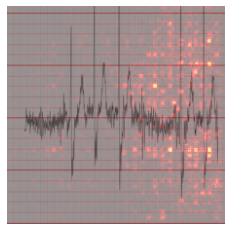

In [224]:
saliency_folder = create_maps_folders(MAP_DIR, HEARTBEAT, config_data['labels_bin'], DELETE_PRIOR_DIR)
saliency, imgs = create_saliency_maps_one_heartbeat(TEST_DATA_PATH, MODELS_PATH, MODEL_NAME, HEARTBEAT, saliency_folder, NR_BATCHES)

In [222]:
saliency.shape

torch.Size([16, 224, 224])

In [41]:
data_prep = DataPreparation(str(TEST_DATA_PATH))
data, size = data_prep.create_dataloaders(16, False, 4)

In [49]:
ab = [str(f) for f in (TEST_DATA_PATH / "abnormal").glob("*.png")]
n = [str(f) for f in (TEST_DATA_PATH / "normal").glob("*.png")]

In [50]:
d = np.concatenate((ab, n))

In [51]:
len(d)

49617

In [52]:
len(data["test"].dataset.samples)

49617

In [60]:
for i, filename in enumerate(data['test'].dataset.samples):
    if not Path(filename[0]).is_file():
        print(filename)
    

## Digging into saliency maps and data

## It's important to differentiate the cases where the model gives the correct prediction from those where the prediction is wrong

In [40]:
i = 15
sal = saliency[i].cpu().numpy() # saliency for one sample
img = imgs[i]

In [5]:
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
roi_file_path = list((Path.cwd().parent / "ROI").glob("*.txt"))[2] # --> label final
roi_file_path

PosixPath('/mnt/Media/bernardo/Documents/PhD/Courses/Deep Structured Learning/code/DSLproject/ROI/5_ROI.txt')

In [33]:
patient = "232"
file = "0_0"
with open(roi_file_path) as rois:
    rois_reader = csv.reader(rois, delimiter='\t')
    for i, roi in enumerate(rois_reader):
        if roi[0] == patient and roi[1] == file:
            img_path = TEST_DATA_PATH / roi[6] / f"{roi[1]}_{roi[0]}.png"
            left_top, right_bottom, img, img_rect = roi_rectangle(img_path, roi)

top_left: (1948, 137)
bottom_right: (2202, 299)


-----------------------------------------------------

## Transforming roi points, only necessary to saliency maps

In [43]:
def transforming_roi_points(left_top, right_bottom):
    """
    parameters: rois extreme points
    """
    crop_x, crop_y = 750, 125 # each side
    y_ratio, x_ratio = 224/200, 224/1500
    top_left_cropped_resized = (int((left_top[0]-crop_x)*x_ratio), int((left_top[1]-crop_y)*y_ratio))
    delta_x_resized = (right_bottom[0] - left_top[0]) * x_ratio
    delta_y_resized = (right_bottom[1] - left_top[1]) * y_ratio
    right_cropped_resized = (int(top_left_cropped_resized[0]+delta_x_resized), int(top_left_cropped_resized[1]+delta_y_resized))
    return top_left_cropped_resized, right_cropped_resized

## First metric:

In [44]:
def metric1(attr_map, top_left, right_bottom):
    roi_sum = np.sum(attr_map[top_left[1]:right_bottom[1], top_left[0]:right_bottom[0]])
    map_sum = np.sum(attr_map)
    return roi_sum/map_sum

--------------------------------------------------------------

## Applying this metric to all test samples

In [45]:
def read_rois_file_as_dict(rois_filename, test_data_path):
    dict_per_row = {}
    with open(rois_filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile,delimiter='\t')
        for i,row in enumerate(reader):
            path = str(test_data_path / row['label'] / f"{row['File']}_{row['Patient']}")
            dict_per_row[path] = row
            
    return dict_per_row

In [46]:
def batch_saliency(model, inputs, labels):
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    x.requires_grad_();
    scores = model(x)
    score_max_index = scores.argmax(dim=1)
    score_max = scores[:, score_max_index]
    score_max.backward(torch.ones_like(score_max))
    saliency, _ = torch.max(x.grad.data.abs(),dim=1)
    return saliency, score_max_index

In [47]:
def create_saliency_metrics_one_heartbeat(data_path, models_main_path, model_name, beat, batches, rois):
    data_prep = DataPreparation(str(data_path))
    data, size = data_prep.create_dataloaders(batches, False, 4)
    model_path = models_main_path / f"label_{beat}/{model_name}.pth"
    model = torch.load(model_path, map_location=torch.device(0))
    model.eval();
    return saliency_metrics(model, data, batches, rois)

In [48]:
def get_roi_points(roi):
    return (int(roi['left']), int(roi["top"])), (int(roi["right"]), int(roi["bottom"]))

In [49]:
def get_roi(sample_path, rois_dict):
    stem_split = sample_path.stem.split("_")
    roi = None
    if f"{stem_split[0]}_{stem_split[1]}" != "0_0":
        try: 
            roi = rois_dict[str(sample_path.parents[1] / "normal" /  sample_path.stem)]
        except KeyError:
            roi = rois_dict[str(sample_path.parents[1] / "abnormal" /  sample_path.stem)]
    return roi

In [70]:
def saliency_metrics(model, data, batch_size, rois_dict):
    classes = data["test"].dataset.classes
    metric_values = []
    pred_verification = []
    for i, (inputs, labels) in enumerate(data['test']):
        print(f"batch nr: {i+1}", end='\r')
        saliency, score_max_index = batch_saliency(model, inputs, labels)
        for index in range(len(saliency)):
            sal = saliency[index].cpu().numpy()
            label = classes[labels[index]]
            sample_path = Path(data['test'].dataset.samples[i*batch_size+index][0])         
            roi = get_roi(sample_path, rois_dict)
            if roi:
                top_left, bottom_right = get_roi_points(roi)
                top_left, bottom_right = transforming_roi_points(top_left, bottom_right)
                metric_values.append(metric1(sal, top_left, bottom_right))    

                true = labels[index]
                pred = score_max_index[index]
                if pred != true:
                    pred_res = "wrong"
                else:
                    pred_res = "ok"
                pred_verification.append(pred_res)
    return metric_values, pred_verification

In [63]:
HEARTBEAT = "initial"
roi_file_path = list((Path.cwd().parent / "ROI").glob("0_ROI.txt"))[0]
MODELS_PATH = Path(f"../models/")
MODEL_NAME = "resnet50_d_22_t_19_13"
TEST_DATA_PATH = Path(f'/mnt/Media/bernardo/DSL_test_data')
NR_BATCHES = 16

In [64]:
rois_dict = read_rois_file_as_dict(roi_file_path, TEST_DATA_PATH)

In [65]:
values, prediction_results = create_saliency_metrics_one_heartbeat(TEST_DATA_PATH, MODELS_PATH, MODEL_NAME, HEARTBEAT, NR_BATCHES, rois_dict)

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [67]:
data_prep = DataPreparation(str(TEST_DATA_PATH))
data, size = data_prep.create_dataloaders(16, False, 4)

In [69]:
len(list(data['test'].dataset.samples)) / 16

3101.0625